In [20]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
from scipy import integrate as integrate
import pandas as pd
from scipy.optimize import minimize
from scipy.special import erf
from matplotlib import cm

In [21]:
plt.style.use('default')
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [1]:
def threematmul(A,B,C):
    result= np.matmul(A.T,B)
    result= np.matmul(result,C)
    return result

In [2]:
def E(z, parameters):   #Flat lambdaCDM universe
    omega_bh2=parameters[1]
    omega_ch2=parameters[2]
    h=parameters[3]/100
    omega_vh2=0.06/93.14
    omega=(omega_bh2+omega_ch2+omega_vh2)/h**2
    #print(omega)
    omega_k=parameters[0]
    omega_x = parameters[4]
    omega_lambda = 1-omega-omega_k
    return ((omega*((1+z)**3)) + (omega_k*((1+z)**2))+ omega_lambda*((1+z)**(3+3*omega_x)))**(1/2)

In [3]:
def f(z,parameters):
    return 1/E(z,parameters)

In [4]:
def erf_new(x):
    return ((4/np.pi)**(1/2))*(erf(x)-erf(0))

In [11]:
def alpha(parameters,sigma_Ho,sigma,z):
    #sigma,z,H_obs are vectors

    n = len(sigma)
    alpha0=1/(sigma_Ho)**2
    for i in range(n):
        alpha0 = alpha0 + (E(parameters,z[i])/sigma[i])**2
        
    return alpha0
        

In [12]:
def beta(parameters,Ho,sigma_Ho,H_obs,sigma,z):
    n = len(sigma)
    beta0=Ho/((sigma_Ho)**2)
    for i in range(n):
        beta0 = beta0 + (E(parameters,z[i])*H_obs[i]/((sigma[i])**2))
        
    return beta0
    

In [13]:
def gamma(Ho,sigma_Ho,H_obs,sigma):
    n = len(sigma)
    gamma0=(Ho/(sigma_Ho))**2
    for i in range(n):
        gamma0 = gamma0 + (H_obs[i]/sigma[i])**2
        
    return gamma0 

# Distance Measures


In [5]:
def Dh(parameters,z):
    c= 3*(10**5)
    Ho= parameters[3]
    return c/(Ho*E(z,parameters))

In [6]:
#Dc
def Dc(parameters,z):
    c= 3*(10**5)
    Ho = parameters[3]
    #print(z)
    #print(f"The parameters are {parameters},z ={z}")
    p2 = integrate.quad(f,0,(z),args=(parameters,))[0]
    
    return (c/Ho)*p2

    

In [7]:
#$Dm
def Dm(parameters,z):
    c= 3*(10**5)
    omega_k = parameters[0]
    Ho = parameters [3]
    dh = c/Ho
    dc= Dc(parameters,z)
    #print(dc)
    
    #print(p1)
   
    if omega_k ==0:
        return dc
    elif omega_k > 0:
        p1= dh/(np.sqrt(omega_k))
        return p1*np.sinh(dc/p1)
    else :
        p2=dh/(np.sqrt(abs(omega_k)))
        return p2*np.sin(dc/p2)
        
        
    

In [8]:
def Da(parameters,z):
    return (Dm(parameters,z)/(1+z))

In [9]:
def Dv(parameters,z):
    c= 3*(10**5)
    Ho=parameters[3]
    return (((c/Ho)*((Dm(parameters,z))**2)*(z/E(z,parameters)))**(1/3))

# Sound Horizon

In [10]:
def rs(parameters,z):
    omega_bh2 = parameters[1]
    omega_ch2 = parameters[2]
    omega_vh2 = 0.06/93.14
    p1=np.exp(-72.3*(omega_vh2+0.0006)**2)
    p2= ((omega_bh2)**(0.12807))*(((omega_ch2+omega_bh2))**(0.25351))
    return 55.154*p1/p2

In [38]:
def Likelihood(parameters,Ho,sigma_Ho,H_obs,sigma,z):
    alpha0= alpha(parameters,sigma_Ho,sigma,z)
    beta0= beta(parameters,Ho,sigma_Ho,H_obs,sigma,z)
    gamma0= gamma(Ho,sigma_Ho,H_obs,sigma)
    LH1= (1/(4*alpha0*((sigma_Ho)**2)))**(1/2)
    LH2= np.exp(-gamma0/2+(((beta0)**2)/(2*alpha0)))
    LH3 = 1+ erf_new(beta0/((2*alpha0)**(1/2)))
    return (LH1*LH2*LH3)


In [11]:
def Chi_sq1(parameters,H_obs1,z_obs1,sigma_obs1):
    #print(z_obs1.shape)
    n = z_obs1.shape[0]
    H_theo1 = np.zeros(n)
    Ho=parameters[3]
    chi_sq=0
    for i in range(n):
        H_theo1[i]= Ho*(E(z_obs1[i],parameters))
        chi_sq= chi_sq+(H_obs1[i]-H_theo1[i])**2/(sigma_obs1[i])**2
    #print((f"H_theo-H_obs for H(z) data { H_theo1-H_obs1}"))
    #print(f"Chi_sq for H(z) data: {chi_sq}")
    return chi_sq
    

In [12]:
def Chi_sq2(parameters,D_obs,z_obs,cov_matrix):
    datapoints= z_obs.shape
    D_theo= np.zeros(datapoints)
    Ho=parameters[3]
    
    dm_indices= [1,3,5,8,10]
    dh_indices=[2,4,6,9,11]
    da_indices = [7]
    dv_indices = [0]
    rs_fid= 147.5
    rs_values = rs(parameters,z_obs)
    #print(rs_values)
    for i in dv_indices:
        #print(z_obs[i].type)
        D_theo[i]= Dv(parameters,z_obs[i])*rs_fid/rs_values
    for i in da_indices:
        D_theo[i]=Da(parameters,z_obs[i])/rs_values
    for i in dm_indices:
        D_theo[i]=Dm(parameters,z_obs[i])/rs_values
    for i in dh_indices:
        D_theo[i]=Dh(parameters,z_obs[i])/rs_values
  
    #print(D_theo)
    D_theo= D_theo-D_obs
    #print((f"D_theo-D_obs for BAO data { D_theo.T}"))
    #result= np.matmul(D_theo.T,np.linalg.inv(cov_matrix))
    #result=np.matmul(result,D_theo)
    cov_1 = 1/(cov_matrix[0,0])
    cov_2= np.linalg.inv((cov_matrix[1:5,1:5]))
    cov_3 = np.linalg.inv((cov_matrix[5:7,5:7]))
    cov_4=1/(cov_matrix [7,7])
    cov_5=np.linalg.inv((cov_matrix[8:10,8:10]))
    cov_6 = np.linalg.inv((cov_matrix[10:12,10:12]))
    result1 = D_theo[0]*cov_1*D_theo[0]
    result2 = threematmul (D_theo[1:5],cov_2,D_theo[1:5])
    result3 = threematmul (D_theo[5:7],cov_3,D_theo[5:7])
    result4 = D_theo[7]*cov_4*D_theo[7]
    result5 = threematmul (D_theo[8:10],cov_5,D_theo[8:10]) 
    result6 = threematmul (D_theo[10:12],cov_6,D_theo[10:12])
    
    #print(f"Chi_sq for BAO data: {result1+result2+result3+result4+result5+result6}")
    #print(result1)
    #print(result2)
    #print(result3)
    #print(result4)
    #print(result5)
    #print(result6)
    
    #return (result1+result2+result3+result4+result5+result6).ravel()
    return(threematmul(D_theo,np.linalg.inv(cov_matrix),D_theo)).ravel()
        
        
    
    
    
    
    


In [13]:
def Chi_sq(parameters,H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix):
    
   
    return Chi_sq2(parameters,D_obs,z_obs,cov_matrix)+ Chi_sq1(parameters,H_obs1,z_obs1,sigma_obs1)

In [14]:
def log_likelihood(parameters,H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix):
    return (-Chi_sq(parameters,H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix)/2)

In [17]:
def log_prior(parameters):
    omega_k,omega_bh2,omega_ch2,Ho,omega_x = parameters
    if -2 < omega_k < 2 and 0<=omega_bh2<=1 and 0<=omega_ch2<=1 and -5< omega_x < 0.33  :
        return 0.0
    return -np.inf
#No prior on Ho

In [18]:
def log_probability(parameters,H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix):
    lp = log_prior(parameters)
    if not np.isfinite(lp):
        return -np.inf
   
    return lp + log_likelihood(parameters,H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix)

# Preparing H data

In [22]:
Data = pd.read_csv("Hdata_Updated.csv")
Data = Data.to_numpy()
z_obs1 = Data[:,0]
z_obs1 = np.reshape(z_obs1,(32,1))
H_obs1 = Data[:,1]
sigma_obs1 = Data[:,2]
print(z_obs1)
print(Data)

[[0.07  ]
 [0.09  ]
 [0.12  ]
 [0.17  ]
 [0.179 ]
 [0.199 ]
 [0.2   ]
 [0.27  ]
 [0.28  ]
 [0.352 ]
 [0.3802]
 [0.4   ]
 [0.4004]
 [0.4247]
 [0.4497]
 [0.47  ]
 [0.4783]
 [0.48  ]
 [0.593 ]
 [0.68  ]
 [0.75  ]
 [0.781 ]
 [0.875 ]
 [0.88  ]
 [0.9   ]
 [1.037 ]
 [1.3   ]
 [1.363 ]
 [1.43  ]
 [1.53  ]
 [1.75  ]
 [1.965 ]]
[[7.000e-02 6.900e+01 1.960e+01]
 [9.000e-02 6.900e+01 1.200e+01]
 [1.200e-01 6.860e+01 2.620e+01]
 [1.700e-01 8.300e+01 8.000e+00]
 [1.790e-01 7.500e+01 4.000e+00]
 [1.990e-01 7.500e+01 5.000e+00]
 [2.000e-01 7.290e+01 2.960e+01]
 [2.700e-01 7.700e+01 1.400e+01]
 [2.800e-01 8.880e+01 3.660e+01]
 [3.520e-01 8.300e+01 1.400e+01]
 [3.802e-01 8.300e+01 1.350e+01]
 [4.000e-01 9.500e+01 1.700e+01]
 [4.004e-01 7.700e+01 1.020e+01]
 [4.247e-01 8.710e+01 1.120e+01]
 [4.497e-01 9.280e+01 1.290e+01]
 [4.700e-01 8.900e+01 5.000e+01]
 [4.783e-01 8.090e+01 9.000e+00]
 [4.800e-01 9.700e+01 6.200e+01]
 [5.930e-01 1.040e+02 1.300e+01]
 [6.800e-01 9.200e+01 8.000e+00]
 [7.500e-01 9.880e+

# Preparing BAO Data

In [23]:
Data = pd.read_csv("BAO_data.csv")
Data=Data.to_numpy()
cov_matrix=np.array([[289,0,0,0,0,0,0,0,0,0,0,0],
[0,0.0286052,-0.04939281,0.01489688,-0.01387079,0,0,0,0,0,0,0],
[0,-0.04939281,0.5307187,-0.02423513,0.1767087,0,0,0,0,0,0,0],
[0,0.01489688,-0.02423513,0.04147534,-0.04873962,0,0,0,0,0,0,0],
[0,-0.01387079,0.1767087,-0.04873962,0.3268589,0,0,0,0,0,0,0],
[0,0,0,0,0,0.1076634008565565,-0.05831820341302727,0,0,0,0,0],
[0,0,0,0,0,-0.05831820341302727,0.2838176386,0,0,0,0,0],
[0,0,0,0,0,0,0,0.1849,0,0,0,0],
[0,0,0,0,0,0,0,0,0.63731604,0.1706891,0,0],
[0,0,0,0,0,0,0,0,0.1706891,0.30468415,0,0],
[0,0,0,0,0,0,0,0,0,0,1.3225,-0.1009],
[0,0,0,0,0,0,0,0,0,0,-0.1009,0.038]])
#cov_matrix = cov_matrix.astype(float)
print(Data)
print((cov_matrix))

[[           nan            nan 1.22000000e-01 5.39000000e+02]
 [           nan            nan 3.80000000e-01 1.02340600e+01]
 [           nan            nan 3.80000000e-01 2.49805800e+01]
 [           nan            nan 5.10000000e-01 1.33659500e+01]
 [           nan            nan 5.10000000e-01 2.23165600e+01]
 [           nan            nan 6.98000000e-01 1.78582369e+01]
 [           nan            nan 6.98000000e-01 1.93257537e+01]
 [           nan            nan 8.10000000e-01 1.07500000e+01]
 [           nan            nan 1.48000000e+00 3.06876000e+01]
 [           nan            nan 1.48000000e+00 1.32609000e+01]
 [           nan            nan 2.33400000e+00 3.75000000e+01]
 [           nan            nan 2.33400000e+00 8.99000000e+00]]
[[ 2.89000000e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.86052000e-02 -4.9392810

In [24]:
z_obs = Data[:,2].astype(float)
z_obs = np.reshape(z_obs, (12,1))
D_obs = Data[:,3].astype(float)
D_obs = np.reshape(D_obs,(12,1))
print(cov_matrix.shape)
print(z_obs.T.shape)
print(z_obs)

(12, 12)
(1, 12)
[[0.122]
 [0.38 ]
 [0.38 ]
 [0.51 ]
 [0.51 ]
 [0.698]
 [0.698]
 [0.81 ]
 [1.48 ]
 [1.48 ]
 [2.334]
 [2.334]]


In [25]:
#Theoretical Values
parameters = [0.048,0.026,0.1098,68.86,-0.53] #parameters as obtained in 2203.10825
#print(np.matmul(D_obs.T,cov_matrix))
print(Chi_sq(parameters,H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix)) 
#Evaluation of Chi_sq(min) value at parameters
#This value obtained in 2203.10825 is equal to 25.30

#print(Chi_sq2(parameters,H_obs1,z_obs1,sigma_obs1))

[318.59566688]


In [274]:
cov_1 = cov_matrix[0,0]
cov_2=  np.linalg.inv(cov_matrix[1:5,1:5])
cov_3 = np.linalg.inv(cov_matrix[5:7,5:7])
cov_4=cov_matrix [7,7]
cov_5= np.linalg.inv(cov_matrix[8:10,8:10])
cov_6 = np.linalg.inv(cov_matrix[10:12,10:12])
cov_7 = np.linalg.inv(cov_matrix)
print(cov_5)
print(cov_6)

[[ 1.84606347 -1.03419529]
 [-1.03419529  3.86146067]]
[[ 0.94824125  2.51783005]
 [ 2.51783005 33.00129086]]


In [96]:
print(Dv(parameters,0.122)*147.5/rs(parameters,0.122))
print(np.linalg.inv(cov_matrix))

0.122
505.25404077758816
13552.618543578767
288.40704582579366


TypeError: No loop matching the specified signature and casting was found for ufunc inv

In [54]:
print(505.25404077758816/0.0007378647873726219)

684751.5282260444


In [43]:
print(np.exp(-3.085))

0.04573003390021825


In [29]:
Ho= 68
sigma_Ho=2.8
[0.05,0.025,0.12,70
 0.048,0.026,0.1098,68.86

In [65]:
print(rs([2.62998306e-01, 1.42092066e-02 ,8.12893791e-03 ,7.64451454e+01],0.122))

249.2653204776462


In [26]:
best_fit_params = minimize (Chi_sq,x0=[0,0,0,70,0],args=(H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix),bounds=[(-0.6,2),(0,1),(0,1),(0,np.inf),(-5,0.33)])
print(best_fit_params)

<ipython-input-10-5039831cf10c>:7: RuntimeWarning: divide by zero encountered in double_scalars
  return 55.154*p1/p2


      fun: array([22.12355213])
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.19015908e-04,  5.82645043e-05, -1.24735777e-03,  1.06581477e-05,
        3.83693075e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 612
      nit: 81
     njev: 102
   status: 0
  success: True
        x: array([-5.45164243e-02,  2.95486565e-02,  9.80935648e-02,  6.58305116e+01,
       -7.27504732e-01])


In [46]:
print(np.round((best_fit_params.x),4))
print(np.round((best_fit_params.fun),4))
sol=best_fit_params.x
print(f"Best Fit \Omega_m {(sol[1]+sol[2]+0.06/93.14)/(sol[3]/100)**2}")
print(f"BIC {best_fit_params.fun+ 5*np.log(44)}")
print()

[-5.45000e-02  2.95000e-02  9.81000e-02  6.58305e+01 -7.27500e-01]
[22.1236]
Best Fit \Omega_m 0.29602350855176246
BIC [41.0445003]



In [29]:
import emcee

pos = best_fit_params.x + 1e-4 * np.random.randn(200, 5)
nwalkers, ndim = pos.shape

#filename = "BAO_LCDM.h5"
#backend = emcee.backends.HDFBackend(filename)
#backend.reset(nwalkers, ndim)

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix)
)

sampler.run_mcmc(pos, 8000, progress=True);

100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [58:29<00:00,  2.28it/s]


In [39]:
#tau = sampler.get_autocorr_time()
#print(tau)
#tau = sampler.get_autocorr_time()
#burnin = int(2 * np.max(tau))
#thin = int(0.5 * np.min(tau))
burnin = 60
thin = 50
flat_samples = sampler.get_chain(discard=360,thin= 50, flat=True)
labels = ["omega_k", "omega_bh2", "omega_ch2", "Ho","omega_x"]
print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(flat_samples.shape))

burn-in: 60
thin: 50
flat chain shape: (30400, 5)


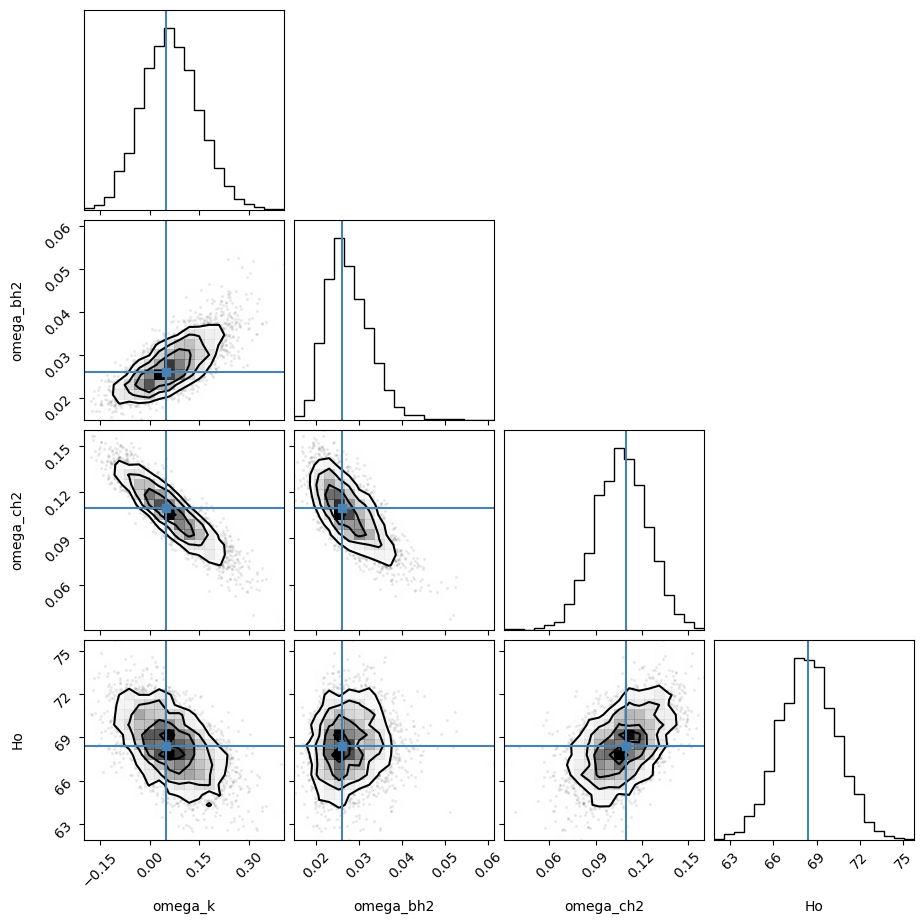

In [54]:
import corner
flat_samples = sampler.get_chain(discard=350, thin=40, flat=True)
fig = corner.corner(
    flat_samples, labels=labels, truths=best_fit_params.x)

In [55]:
from IPython.display import display, Math

for i in range(4):
    mcmc = np.percentile(flat_samples[:, i], [2.28, 50, 97.7])
    q = np.diff(mcmc)
    minimum = mcmc[1]-q[0]
    maximum = mcmc[1]+q[1]
    #print(f"{minimum} $\le \Omega \ge$ {maximum}")
    txt = "\mathrm{{{3}}} = {0:.2f}_{{{1:.2f}}}^{{{2:.2f}}}"
    txt = txt.format(mcmc[1], mcmc[1]-q[0], mcmc[1]+q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [40]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt
import IPython
print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))

GetDist Version: 1.3.4, Matplotlib version: 3.3.2


In [41]:
names = ["omega_k","omega_bh2","omega_ch2","Ho","omega_x"]
labels =  ["\Omega_{ko}","\Omega_{b} h^2","\Omega_{c} h^2","H_o","\omega_x"]
samples2 = MCSamples(samples=flat_samples,names = names, labels = labels)

Removed no burn in


In [42]:
p = samples2.getParams() 
print(p)
assert np.all(p.omega_k == samples2['omega_k'])
samples2.addDerived((0.06/93.14+ p.omega_bh2+ p.omega_ch2)/(p.Ho/100)**2, name='omega', label='\Omega_m')



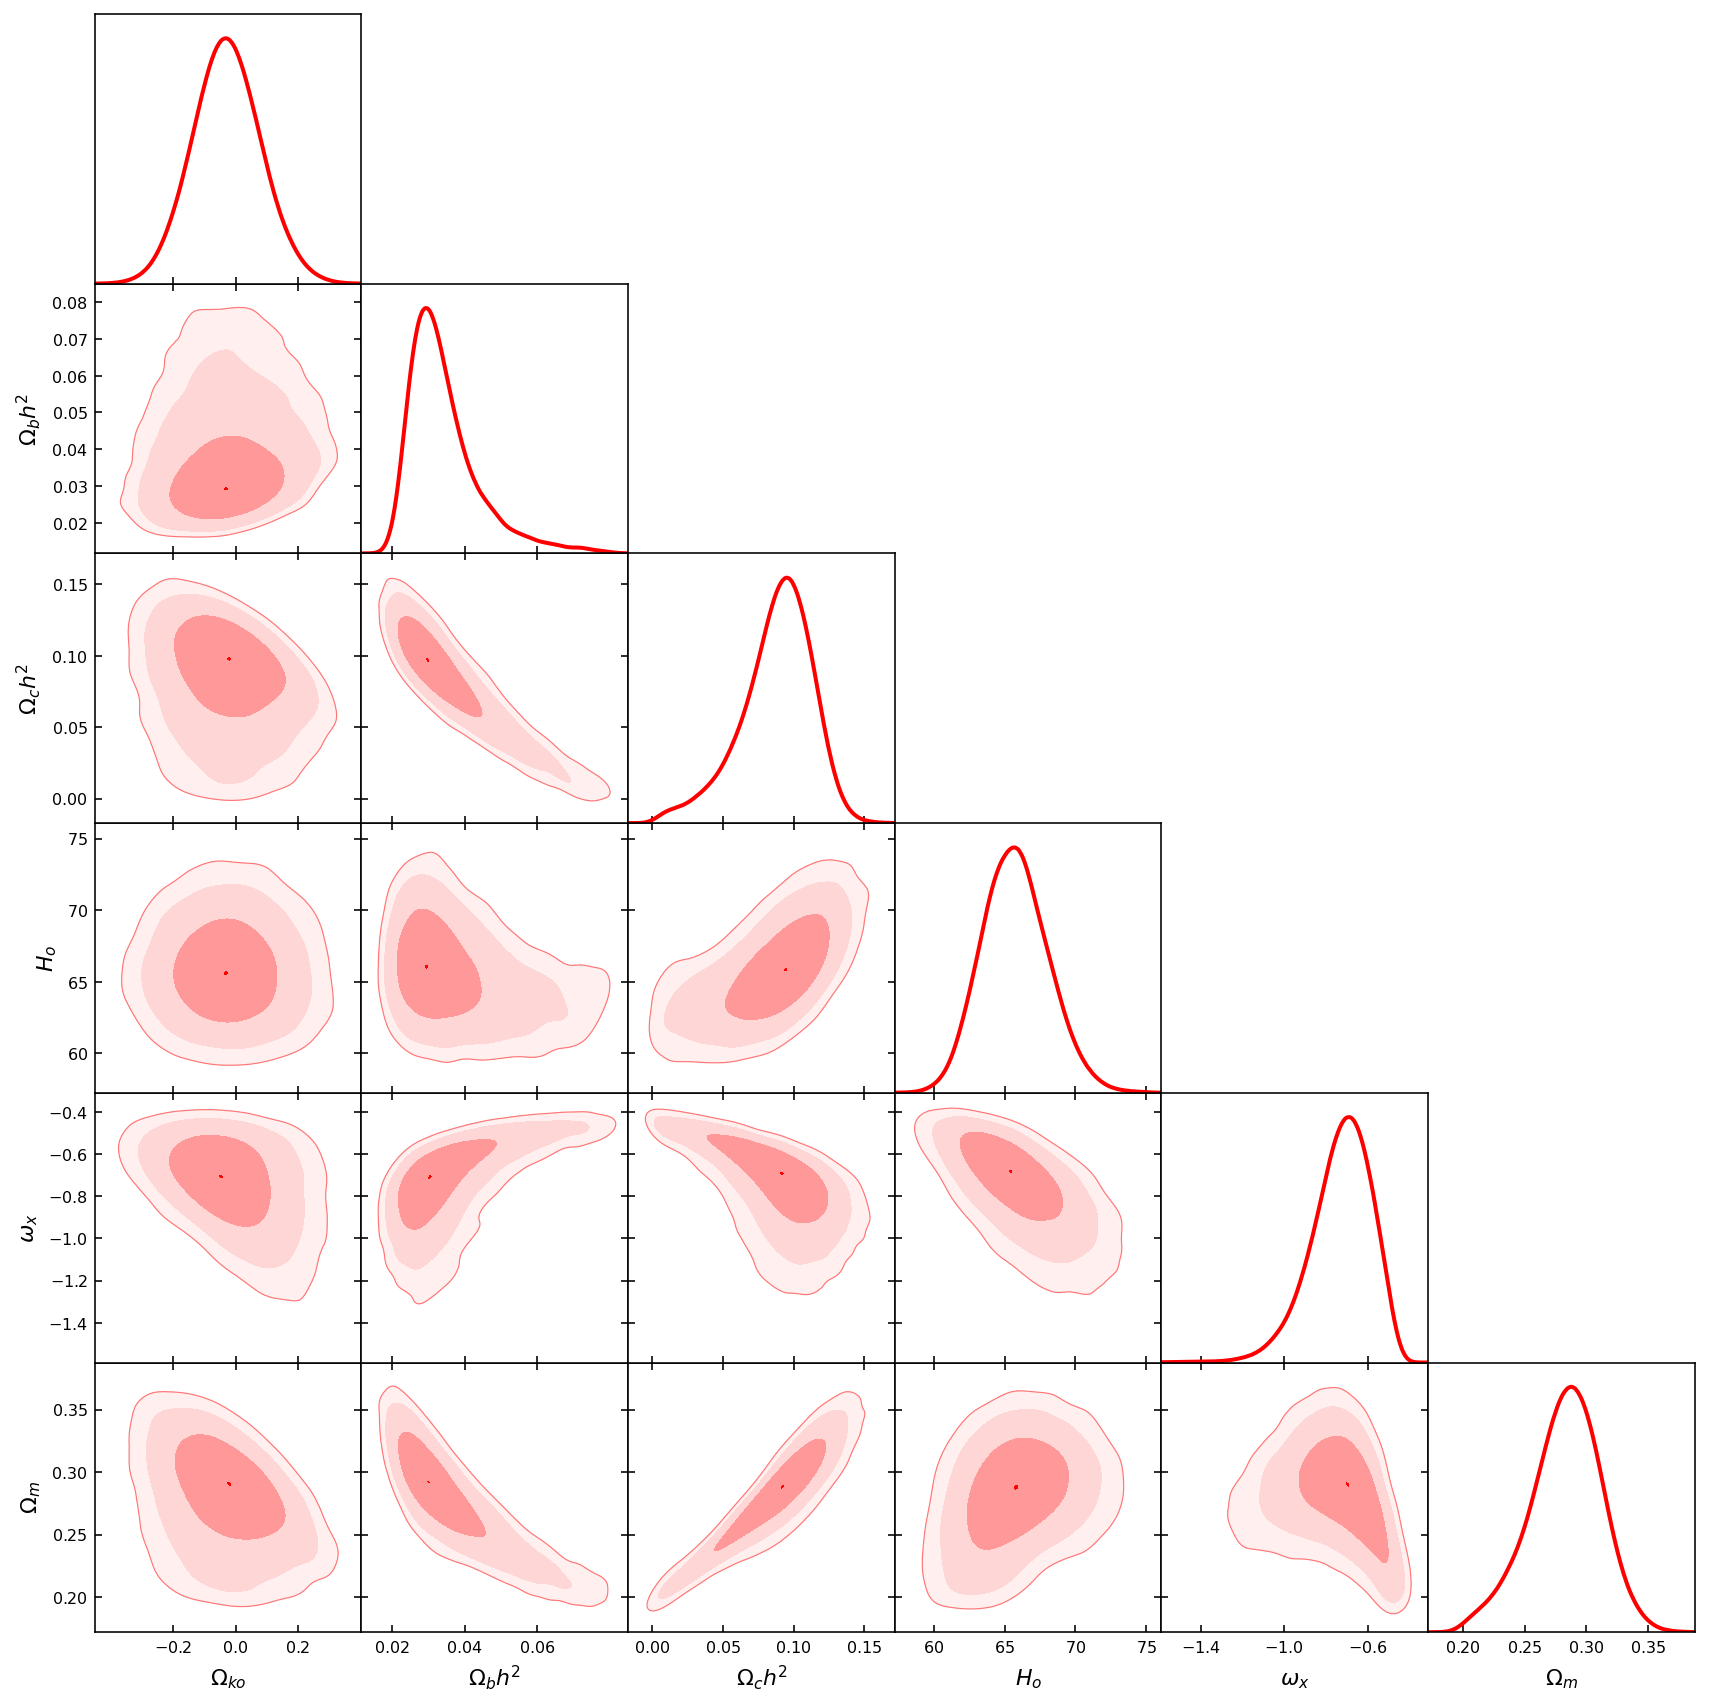

In [54]:
from matplotlib import cm
samples2.updateSettings({'contours': [0.001,0.68, 0.95, 0.99]})
g = plots.get_subplot_plotter(subplot_size=2)
g.settings.num_plot_contours = 4
g.triangle_plot([samples2], filled=True,contour_lws=2,contour_colors=['red']);
g.export("BAO_XCDM.png")

In [37]:
print(samples2.getTable().tableTex())

\begin{tabular} { l  c}

 Parameter &  68\% limits\\
\hline
{\boldmath$\Omega_{ko}    $} & $-0.03^{+0.11}_{-0.11}     $\\

{\boldmath$\Omega_{b} h^2 $} & $0.0344^{+0.0040}_{-0.011} $\\

{\boldmath$\Omega_{c} h^2 $} & $0.088^{+0.029}_{-0.018}   $\\

{\boldmath$H_o            $} & $65.8^{+2.2}_{-2.5}        $\\

{\boldmath$\omega_x       $} & $-0.73^{+0.17}_{-0.11}     $\\

$\Omega_m                  $ & $0.283^{+0.032}_{-0.025}   $\\
\hline
\end{tabular}


In [53]:
for i in ["omega_k","omega_bh2","omega_ch2","Ho","omega_x","omega"]:
    print(samples2.getInlineLatex(i,limit=1))

\Omega_{ko} = -0.0282^{-0.0011}_{-0.0013}
\Omega_{b} h^2 = 0.034\pm 0.010
\Omega_{c} h^2 = 0.088\pm 0.026
H_o = 65.8\pm 2.4
\omega_x = -0.73\pm 0.15
\Omega_m = 0.283\pm 0.029
